In [141]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso

import ast

import matplotlib.pyplot as plt
%matplotlib inline

### Load the data

In [134]:
dftrain = pd.read_pickle('data_train.p')
dfval = pd.read_pickle('data_val.p')
dftest = pd.read_pickle('data_test.p')

In [135]:
dftrain.columns

Index(['business_id', 'date', 'stars', 'text', 'user_id', 'cos_sim_all',
       'cos_sim_noun', 'cos_sim_adj', 'cos_sim_verb', 'count_review_bus',
       'avg_stars_bus', 'count_funny_bus', 'count_cool_bus',
       'count_useful_bus', 'avg_sent_score_compound_bus',
       'avg_sent_score_net_bus', 'avg_review_length_bus', 'avg_punc_count_bus',
       'avg_word_len_bus', 'count_review_user', 'avg_stars_user',
       'count_funny_user', 'count_cool_user', 'count_useful_user',
       'avg_sent_score_compound_user', 'avg_sent_score_net_user',
       'avg_review_length_user', 'avg_punc_count_user', 'avg_word_len_user',
       'RestaurantsPriceRange2', 'Alcohol', 'BusinessAcceptsCreditCards',
       'GoodForKids', 'OutdoorSeating', 'RestaurantsAttire',
       'RestaurantsGoodForGroups', 'RestaurantsTableService',
       'RestaurantsTakeOut', 'BikeParking', 'Caters', 'DogsAllowed',
       'GoodForMeal', 'HasTV', 'NoiseLevel', 'RestaurantsDelivery',
       'RestaurantsReservations', 'Wheelchai

In [136]:
extra_columns = ['business_id', 
                 'date', 
                 'text', 
                 'user_id', 
                 'GoodForMeal', 
                 'Music',
                 'BestNights',
                 'HairSpecializesIn',
                 'DietaryRestrictions']
dummy_cols = ['NoiseLevel', 'WiFi', 'Smoking', 'AgesAllowed']
target = 'stars'

In [137]:
def data_to_model(raw_data, dummy_cols, extra_columns, normalize_using=None):
    df_X = raw_data.drop(extra_columns + dummy_cols + [target], axis=1)
    if normalize_using is not None:
        df_norm = normalize_using.drop(extra_columns + dummy_cols + [target], axis=1)
    df_y = raw_data[target]
    
    for dummy_col in dummy_cols:
        df_dummy = pd.get_dummies(raw_data[dummy_col], prefix=dummy_col)
        df_X = df_X.join(df_dummy)
        if normalize_using is not None:
            norm_dummy = pd.get_dummies(normalize_using[dummy_col], prefix=dummy_col)
            df_norm = df_norm.join(norm_dummy)
        
    if normalize_using is None:
        df_norm = df_X
        
    normalize(df_X, df_norm)
    return df_X.fillna(0), df_y


def normalize(df_X, normalize_using):
    # memory saving normalization
    for col in df_X.columns:
        # print('normalizing %s' % col)
        norm_mean = np.mean(normalize_using[col].astype(float))
        norm_std = np.std(normalize_using[col].astype(float))
        df_X[col] = (df_X[col].astype(float) - norm_mean) / norm_std
        
        
def mse_loss(preds, truths):
    assert len(preds) == len(truths)
    sse = 0.
    for i in range(len(preds)):
        sse += (preds[i] - truths[i]) ** 2
    return - sse / len(preds)

In [138]:
df_X, df_y = data_to_model(dftrain, dummy_cols, extra_columns, dftrain)
df_Xval, df_yval = data_to_model(dfval, dummy_cols, extra_columns, dftrain)
df_Xtest, df_ytest = data_to_model(dftest, dummy_cols, extra_columns, dftrain)

In [139]:
X = df_X.values
y = df_y.values

### Models

In [140]:
lr = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(X, y)
lin_r = RidgeClassifier().fit(X, y)

### Validation Data

In [142]:
# filling missing dummies with 0
for col in df_X.columns:
    if col not in df_Xval.columns:
        df_Xval[col] = 0
        df_Xtest[col] = 0

In [143]:
preds_lr = lr.predict(df_Xval.values)
preds_lin = lin_r.predict(df_Xval.values)

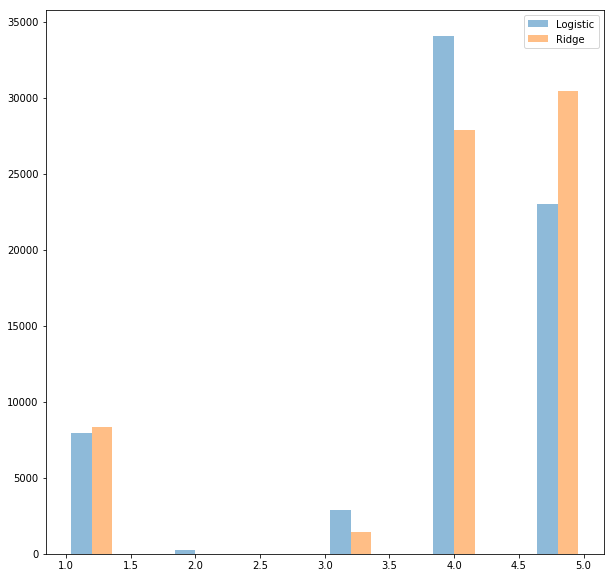

In [145]:
plt.figure(figsize=(10, 10))
plt.hist([preds_lr, preds_lin], label=['Logistic', 'Ridge'], alpha=0.5)
# plt.hist(preds_lin, label='Linear Regression', alpha=0.5)
plt.legend()
plt.show()

### Scoring

In [146]:
lr.score(df_Xval, df_yval)

0.46235390849826746

In [147]:
lin_r.score(df_Xval, df_yval)

0.45191460621366064

In [148]:
mse_loss(preds_lr, df_yval)

-1.5723556704058261

In [149]:
mse_loss(preds_lin, df_yval)

-1.8216802725083692

### What happens if we drop the average rating field of the restaurant and the user?

In [150]:
extra_columnsx = ['business_id', 
                 'date', 
                 'text', 
                 'user_id', 
                 'GoodForMeal', 
                 'Music',
                 'BestNights',
                 'HairSpecializesIn',
                 'DietaryRestrictions',
                 'avg_stars_bus',
                 'avg_stars_user',
                 'average_stars']
dummy_colsx = ['NoiseLevel', 'WiFi', 'Smoking', 'AgesAllowed']
targetx = 'stars'

In [151]:
df_Xx, df_yx = data_to_model(dftrain, dummy_colsx, extra_columnsx, dftrain)
df_Xvalx, df_yvalx = data_to_model(dfval, dummy_colsx, extra_columnsx, dftrain)
df_Xtestx, df_ytestx = data_to_model(dftest, dummy_colsx, extra_columnsx, dftrain)

In [152]:
Xx = df_Xx.values
yx = df_yx.values

In [155]:
lrx = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(Xx, yx)
lin_rx = RidgeClassifier().fit(Xx, yx)

In [156]:
# filling missing dummies with 0
for col in df_Xx.columns:
    if col not in df_Xvalx.columns:
        df_Xvalx[col] = 0
        df_Xtestx[col] = 0

In [157]:
preds_lrx = lrx.predict(df_Xvalx.values)
preds_linx = lin_rx.predict(df_Xvalx.values)

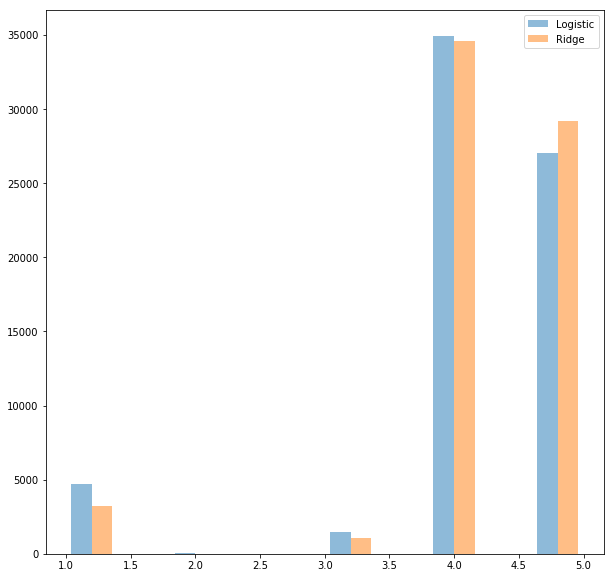

In [158]:
plt.figure(figsize=(10, 10))
plt.hist([preds_lrx, preds_linx], label=['Logistic', 'Ridge'], alpha=0.5)
# plt.hist(preds_lin, label='Linear Regression', alpha=0.5)
plt.legend()
plt.show()

### Scoring

In [159]:
lrx.score(df_Xvalx, df_yvalx)

0.39443237211487636

In [160]:
lin_rx.score(df_Xvalx, df_yvalx)

0.3891026017501615

In [161]:
mse_loss(preds_lrx, df_yvalx)

-2.3658454219768603

In [162]:
mse_loss(preds_linx, df_yvalx)

-2.4462471369002174

### What is baseline random?

In [31]:
len(df_yval)

68108

In [32]:
df_yval.unique()

array([5, 4, 3, 2, 1])

In [33]:
from tqdm import tqdm_notebook as tqdm

rand_mses = []

for i in tqdm(range(100)):
    rand_vals = np.random.randint(1, 6, len(df_yval))
    rand_mse = mse(rand_vals, df_yval)
    rand_mses.append(rand_mse)

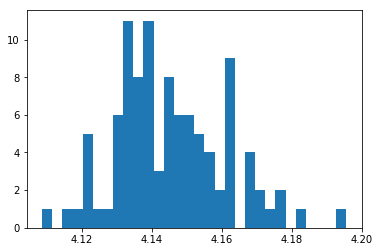

In [34]:
plt.hist(rand_mses, bins=30)
plt.show()

### Baseline MSE = 4.15

In [35]:
np.mean(rand_mses)

4.145428877664885

### Cross Validation

In [46]:
lrf = LogisticRegression(solver='lbfgs', multi_class='multinomial')
scores_lrf = cross_val_score(lrf, df_X, df_y, cv=5, scoring='neg_mean_squared_error')
scores_lrf

array([-1.54999454, -1.47624852, -1.52368823, -1.52431636, -1.78519705])

In [53]:
enf = ElasticNet()
scores_enf = cross_val_score(enf, df_X, df_y, cv=5, scoring='neg_mean_squared_error')
scores_enf

array([-1.3084535 , -1.40210677, -1.45205869, -1.53432998, -1.79368422])

In [55]:
rdf = RidgeClassifier(alpha=0)
scores_rdf = cross_val_score(rdf, df_X, df_y, cv=5, scoring='neg_mean_squared_error')
scores_rdf

array([-1.69188225, -1.66676976, -1.68470271, -1.68613431, -1.94960154])

In [78]:
lsf = Lasso(alpha=0.1)
scores_lsf = cross_val_score(lsf, df_X, df_y, cv=5, scoring='neg_mean_squared_error')
scores_lsf

array([-0.99711542, -1.05080387, -1.0893635 , -1.12674239, -1.29243968])

### Excluding star columns

In [49]:
lrfx = LogisticRegression(solver='lbfgs', multi_class='multinomial')
scores_lrfx = cross_val_score(lrfx, df_Xx, df_yx, cv=5, scoring='neg_mean_squared_error')
scores_lrfx

array([-2.14963796, -1.99290458, -2.03733353, -2.04170078, -2.4805502 ])

In [57]:
enfx = ElasticNet()
scores_enfx = cross_val_score(enfx, df_Xx, df_yx, cv=5, scoring='neg_mean_squared_error')
scores_enfx

array([-1.3830723 , -1.47679653, -1.52638958, -1.60707265, -1.85574535])

In [59]:
rdfx = RidgeClassifier(alpha=0)
scores_rdfx = cross_val_score(rdfx, df_Xx, df_yx, cv=5, scoring='neg_mean_squared_error')
scores_rdfx

array([-2.17108758, -2.03396707, -2.06502438, -2.04923312, -2.4160329 ])

In [61]:
lsfx = Lasso(alpha=0.1)
scores_lsfx = cross_val_score(lsfx, df_Xx, df_yx, cv=5, scoring='neg_mean_squared_error')
scores_lsfx

array([-1.31681729, -1.402675  , -1.45405245, -1.51461107, -1.74341518])

### statsmodels

In [63]:
import statsmodels.api as sm

In [76]:
res = sm.OLS(df_y, df_X).fit()

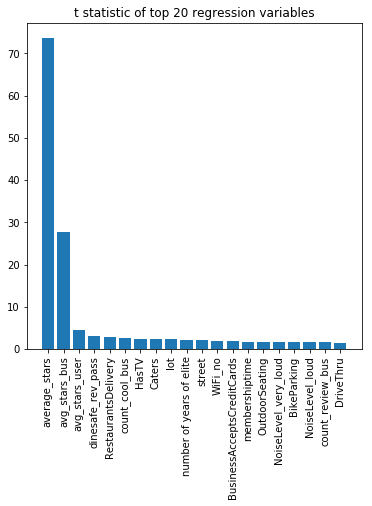

In [75]:
plt.figure(figsize=(6,6))
s = np.abs(res.tvalues).sort_values(ascending=False)
plt.bar(s.index[:20], s.values[:20])
plt.title('t statistic of top 20 regression variables')
plt.xticks(rotation=90)
plt.show()

## For each model let's search over predefined hparameters

## Logistic Regression Search

In [102]:
preds_dict = {}

In [107]:
Cs = [0.001, 0.01, 0.1, 1, 10]
res_dict = {}
preds_dict['LR'] = {}

for C in tqdm(Cs):
    # cross validation
    lrf = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=C)
    scores_lrf = cross_val_score(lrf, df_X, df_y, cv=10, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores_lrf)
    std_score = np.std(scores_lrf)
    
    # validation set
    m = lrf.fit(df_X, df_y)
    preds = m.predict(df_Xval)
    val_loss = mse_loss(preds, df_yval)
    
    preds_dict['LR'][C] = preds
    
    res_dict[C] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
        'val_loss': val_loss
    }
    
df_lr = pd.DataFrame(res_dict).T
df_lr

,cv_mean,cv_std,val_loss
0.001,-1.560843,0.110129,-1.580739
0.010,-1.560941,0.113283,-1.572826
0.100,-1.561942,0.114323,-1.572297
1.000,-1.561865,0.113541,-1.572356
10.000,-1.561618,0.114073,-1.571915


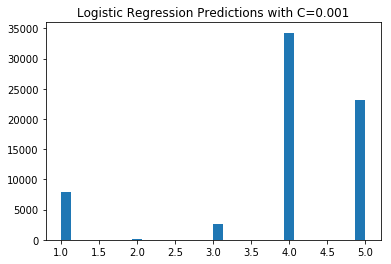

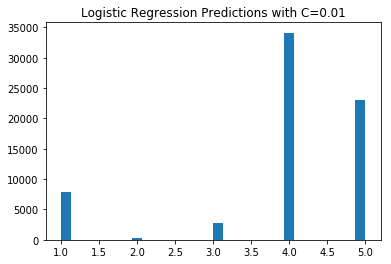

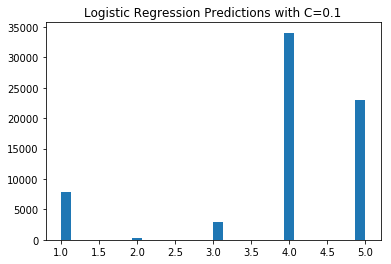

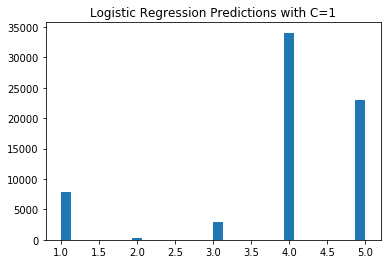

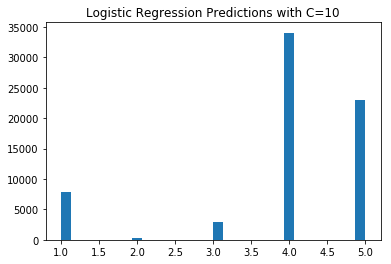

In [108]:
for C in Cs:
    plt.hist(preds_dict['LR'][C], bins=30)
    plt.title('Logistic Regression Predictions with C=%s' % C)
    plt.show()

## Ridge Regression Search - L2 regularization

In [113]:
ridge_alphas = [0.001, 0.01, 0.1, 1, 10]
res_dict = {}
preds_dict['Ridge'] = {}

for alpha in tqdm(ridge_alphas):
    # cross validation
    mod = RidgeClassifier(alpha=alpha)
    scores = cross_val_score(mod, df_X, df_y, cv=10, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # validation set
    m = mod.fit(df_X, df_y)
    preds = m.predict(df_Xval)
    val_loss = mse_loss(preds, df_yval)
    
    preds_dict['Ridge'][alpha] = preds
    
    res_dict[alpha] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
        'val_loss': val_loss
    }
    
df_rd = pd.DataFrame(res_dict).T
df_rd

,cv_mean,cv_std,val_loss
0.001,-1.726890,0.114585,-1.821680
0.010,-1.726890,0.114585,-1.821680
0.100,-1.726890,0.114585,-1.821680
1.000,-1.726894,0.114583,-1.821680
10.000,-1.726981,0.114622,-1.821548


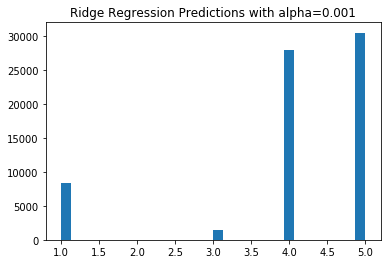

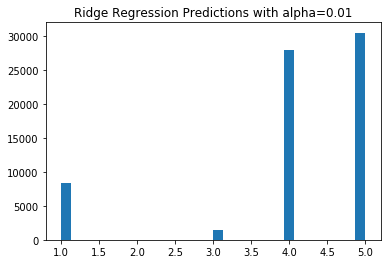

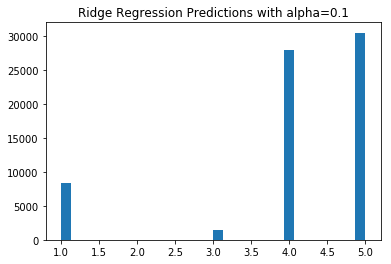

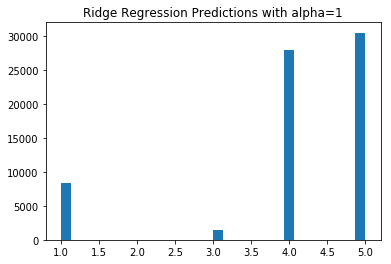

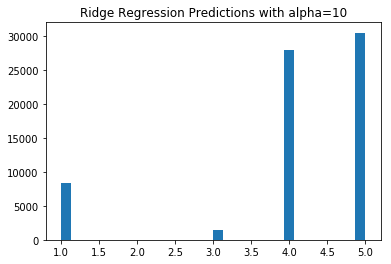

In [114]:
for alpha in ridge_alphas:
    plt.hist(preds_dict['Ridge'][alpha], bins=30)
    plt.title('Ridge Regression Predictions with alpha=%s' % alpha)
    plt.show()

## Lasso Search - L1 regularization

In [118]:
lasso_alphas = [0.01, 0.05, 0.1, 1, 10]
res_dict = {}
preds_dict['Lasso'] = {}

for alpha in tqdm(lasso_alphas):
    # cross validation
    mod = Lasso(alpha=alpha)
    scores = cross_val_score(mod, df_X, df_y, cv=10, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # validation set
    m = mod.fit(df_X, df_y)
    preds = np.round(m.predict(df_Xval))
    val_loss = mse_loss(preds, df_yval)
    
    preds_dict['Lasso'][alpha] = preds
    
    res_dict[alpha] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
        'val_loss': val_loss
    }
    
df_ls = pd.DataFrame(res_dict).T
df_ls

,cv_mean,cv_std,val_loss
0.01,-1.085031,0.109014,-1.180052
0.05,-1.096624,0.107345,-1.192679
0.10,-1.110073,0.105082,-1.212310
1.00,-1.566944,0.168468,-1.917836
10.00,-1.566944,0.168468,-1.917836


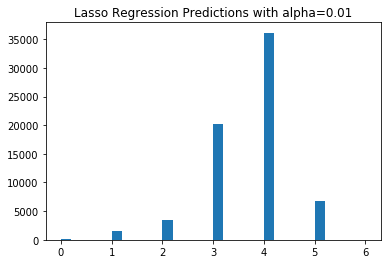

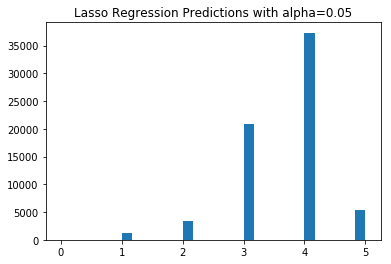

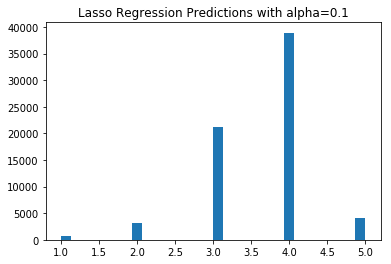

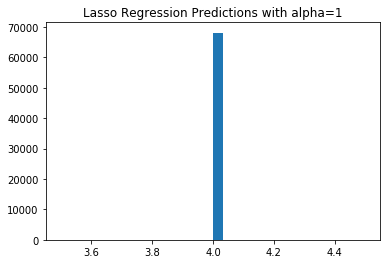

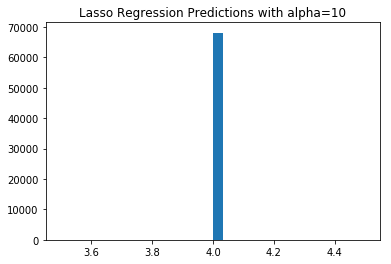

In [119]:
for alpha in lasso_alphas:
    plt.hist(preds_dict['Lasso'][alpha], bins=30)
    plt.title('Lasso Regression Predictions with alpha=%s' % alpha)
    plt.show()

## Elastic Net Search - L1 + L2 regularization

In [123]:
en_alphas = [0.01, 0.05, 0.1, 1, 10]
res_dict = {}
preds_dict['ElasticNet'] = {}

for alpha in tqdm(en_alphas):
    # cross validation
    mod = ElasticNet(alpha=alpha/2)
    scores = cross_val_score(mod, df_X, df_y, cv=10, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # validation set
    m = mod.fit(df_X, df_y)
    preds = np.round(m.predict(df_Xval))
    val_loss = mse_loss(preds, df_yval)
    
    preds_dict['ElasticNet'][alpha] = preds
    
    res_dict[alpha] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
        'val_loss': val_loss
    }
    
df_en = pd.DataFrame(res_dict).T
df_en

,cv_mean,cv_std,val_loss
0.01,-1.082867,0.107322,-1.180566
0.05,-1.086198,0.108859,-1.180860
0.10,-1.091961,0.108198,-1.186498
1.00,-1.251806,0.124783,-1.353615
10.00,-1.566944,0.168468,-1.917836


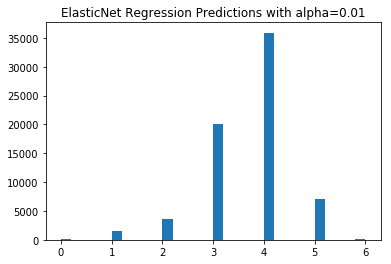

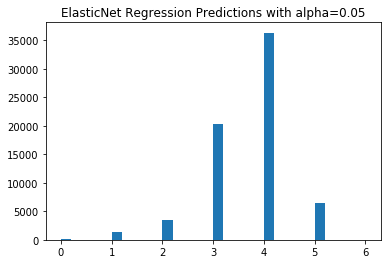

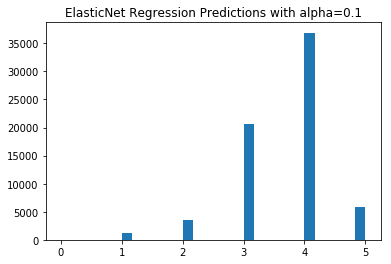

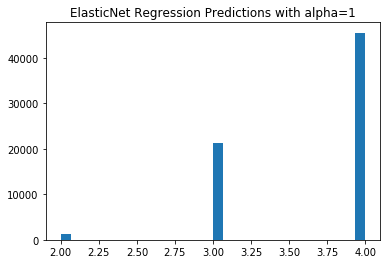

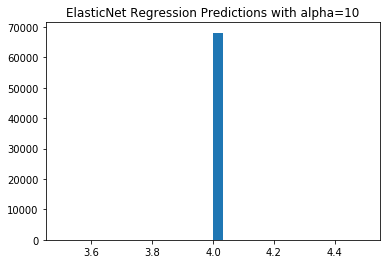

In [124]:
for alpha in en_alphas:
    plt.hist(preds_dict['ElasticNet'][alpha], bins=30)
    plt.title('ElasticNet Regression Predictions with alpha=%s' % alpha)
    plt.show()

# Excluding the 3 star parameters:

### Logistic Regression

In [125]:
preds_dictx = {}

In [126]:
Cs = [0.001, 0.01, 0.1, 1, 10]
res_dict = {}
preds_dictx['LR'] = {}

for C in tqdm(Cs):
    # cross validation
    lrf = LogisticRegression(solver='lbfgs', multi_class='multinomial', C=C)
    scores_lrf = cross_val_score(lrf, df_Xx, df_yx, cv=10, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores_lrf)
    std_score = np.std(scores_lrf)
    
    # validation set
    m = lrf.fit(df_Xx, df_yx)
    preds = m.predict(df_Xvalx)
    val_loss = mse_loss(preds, df_yvalx)
    
    preds_dictx['LR'][C] = preds
    
    res_dict[C] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
        'val_loss': val_loss
    }
    
df_lrx = pd.DataFrame(res_dict).T
df_lrx

,cv_mean,cv_std,val_loss
0.001,-2.104556,0.169795,-2.366785
0.010,-2.111273,0.174174,-2.365875
0.100,-2.112026,0.174688,-2.365405
1.000,-2.112201,0.175623,-2.365845
10.000,-2.111775,0.176058,-2.365273


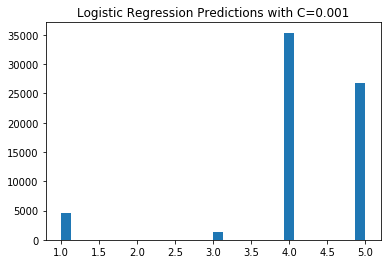

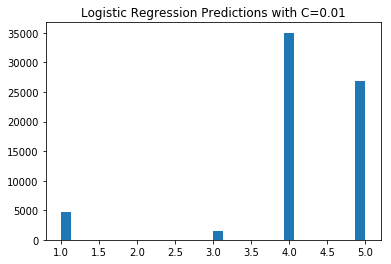

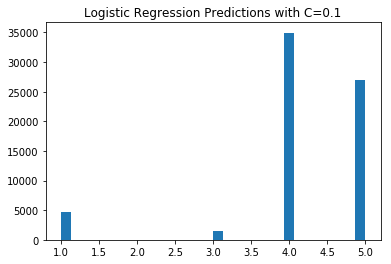

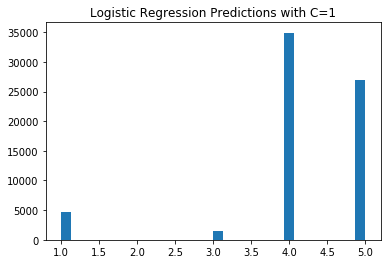

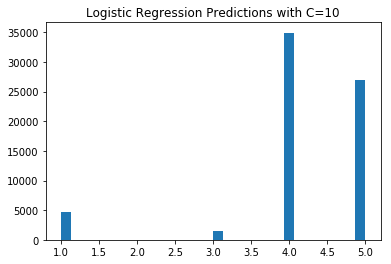

In [127]:
for C in Cs:
    plt.hist(preds_dictx['LR'][C], bins=30)
    plt.title('Logistic Regression Predictions with C=%s' % C)
    plt.show()

### Ridge

In [128]:
ridge_alphas = [0.001, 0.01, 0.1, 1, 10]
res_dict = {}
preds_dictx['Ridge'] = {}

for alpha in tqdm(ridge_alphas):
    # cross validation
    mod = RidgeClassifier(alpha=alpha)
    scores = cross_val_score(mod, df_Xx, df_yx, cv=10, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # validation set
    m = mod.fit(df_Xx, df_yx)
    preds = m.predict(df_Xvalx)
    val_loss = mse_loss(preds, df_yvalx)
    
    preds_dictx['Ridge'][alpha] = preds
    
    res_dict[alpha] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
        'val_loss': val_loss
    }
    
df_rd = pd.DataFrame(res_dict).T
df_rd

,cv_mean,cv_std,val_loss
0.001,-2.125424,0.147019,-2.446277
0.010,-2.125424,0.147019,-2.446277
0.100,-2.125424,0.147019,-2.446277
1.000,-2.125438,0.147070,-2.446247
10.000,-2.125456,0.147059,-2.446232


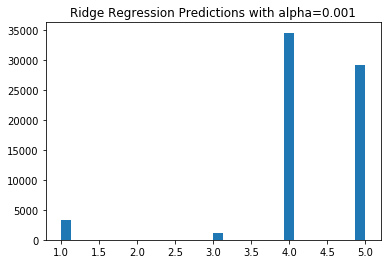

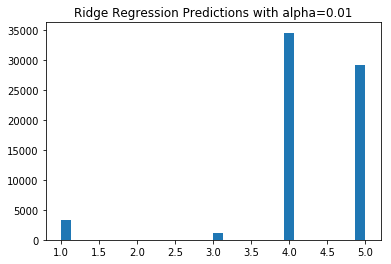

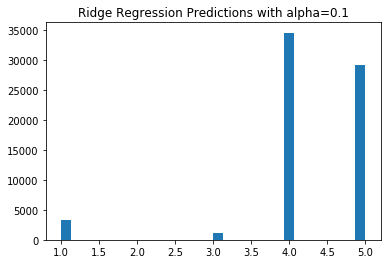

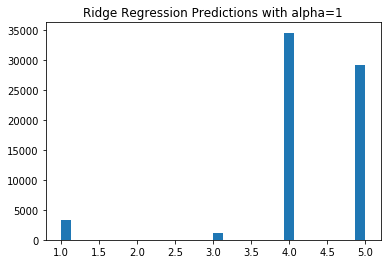

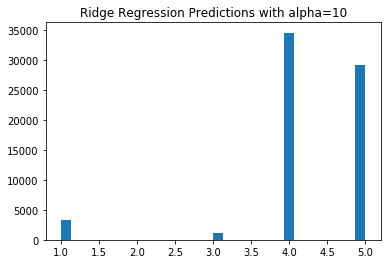

In [129]:
for alpha in ridge_alphas:
    plt.hist(preds_dictx['Ridge'][alpha], bins=30)
    plt.title('Ridge Regression Predictions with alpha=%s' % alpha)
    plt.show()

### Lasso

In [130]:
lasso_alphas = [0.01, 0.05, 0.1, 1, 10]
res_dict = {}
preds_dictx['Lasso'] = {}

for alpha in tqdm(lasso_alphas):
    # cross validation
    mod = Lasso(alpha=alpha)
    scores = cross_val_score(mod, df_Xx, df_yx, cv=10, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # validation set
    m = mod.fit(df_Xx, df_yx)
    preds = np.round(m.predict(df_Xvalx))
    val_loss = mse_loss(preds, df_yvalx)
    
    preds_dictx['Lasso'][alpha] = preds
    
    res_dict[alpha] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
        'val_loss': val_loss
    }
    
df_ls = pd.DataFrame(res_dict).T
df_ls

,cv_mean,cv_std,val_loss
0.01,-1.429081,0.164273,-1.623759
0.05,-1.459068,0.157168,-1.642670
0.10,-1.484689,0.152717,-1.666207
1.00,-1.566944,0.168468,-1.917836
10.00,-1.566944,0.168468,-1.917836


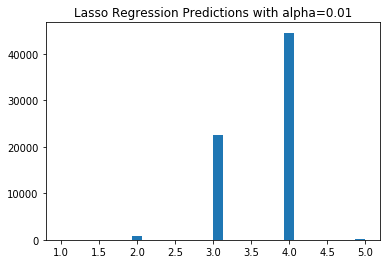

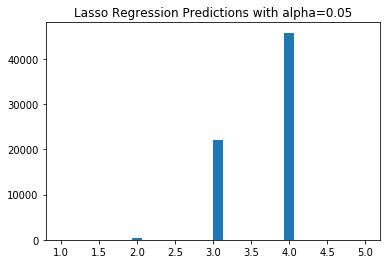

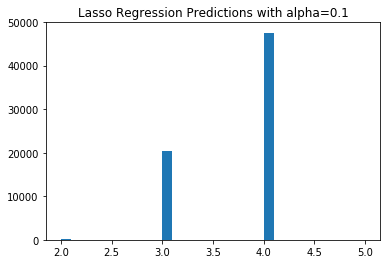

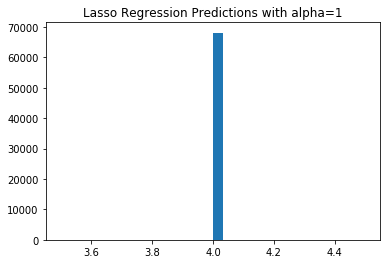

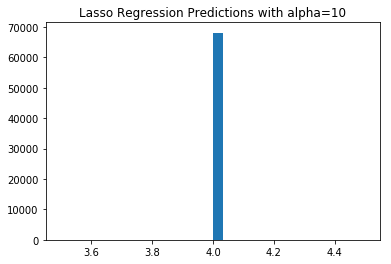

In [131]:
for alpha in lasso_alphas:
    plt.hist(preds_dictx['Lasso'][alpha], bins=30)
    plt.title('Lasso Regression Predictions with alpha=%s' % alpha)
    plt.show()

### Elastic Net

In [132]:
en_alphas = [0.01, 0.05, 0.1, 1, 10]
res_dict = {}
preds_dictx['ElasticNet'] = {}

for alpha in tqdm(en_alphas):
    # cross validation
    mod = ElasticNet(alpha=alpha/2)
    scores = cross_val_score(mod, df_Xx, df_yx, cv=10, scoring='neg_mean_squared_error')
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    # validation set
    m = mod.fit(df_Xx, df_yx)
    preds = np.round(m.predict(df_Xvalx))
    val_loss = mse_loss(preds, df_yvalx)
    
    preds_dictx['ElasticNet'][alpha] = preds
    
    res_dict[alpha] = {
        'cv_mean': mean_score,
        'cv_std': std_score,
        'val_loss': val_loss
    }
    
df_en = pd.DataFrame(res_dict).T
df_en

,cv_mean,cv_std,val_loss
0.01,-1.425703,0.162797,-1.624185
0.05,-1.430577,0.164020,-1.624905
0.10,-1.440890,0.163087,-1.630616
1.00,-1.555861,0.170109,-1.852793
10.00,-1.566944,0.168468,-1.917836


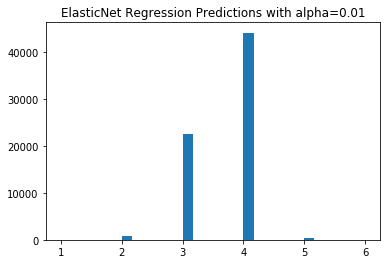

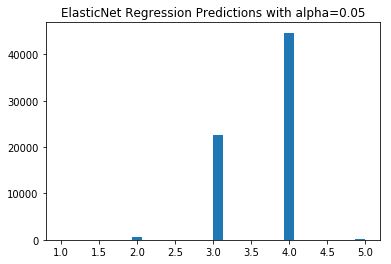

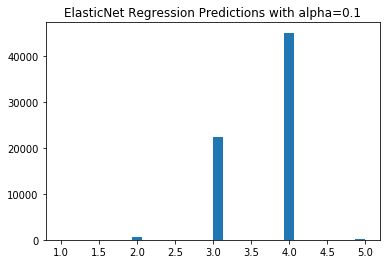

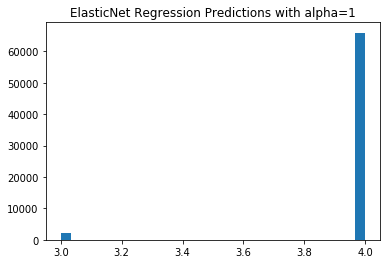

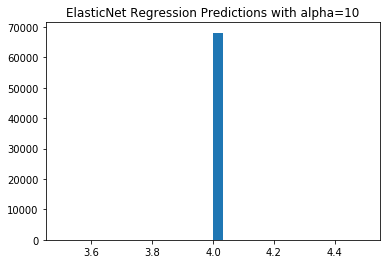

In [133]:
for alpha in en_alphas:
    plt.hist(preds_dictx['ElasticNet'][alpha], bins=30)
    plt.title('ElasticNet Regression Predictions with alpha=%s' % alpha)
    plt.show()